## 暂退法

神经网络模型出现过拟合现象的主要原因包括：①样本数据分布区间不稳定，样本值会出现范围很大的变化区间；②神经网络模型过于复杂，神经元过多，考虑了过多不必要的样本特征；③训练样本少。

其中，第一种过拟合原因可以通过数据预处理、数据缩放等方法解决，第三种过拟合方法可以通过添加样本数据集的方法解决。

针对第二种过拟合方法，可以使用暂退法解决，暂退法的主要思想是通过减少神经网络隐藏层中隐藏单元的数量来降低模型复杂度，从而避免过拟合。

暂退法在前向传播过程中，计算每一内部层的同时注入噪声，当训练一个有多层的深度网络时，注入噪声只会在输入-输出映射上增强平滑性。在整个训练过程的每一次迭代中，标准暂退法包括在计算下一层之前将当前层中的一些节点置零。

在标准暂退法正则化中，通过按保留（未丢弃）的节点的分数进行规范化来消除每一层的偏差。换言之，每个中间活性值$h$以暂退概率$p$由随机变量$h'$替换，如下所示：

$$
\begin{aligned}
h' =
\begin{cases}
    0 & \text{ 概率为 } p \\
    \frac{h}{1-p} & \text{ 其他情况}
\end{cases}
\end{aligned}
$$

根据此模型的设计，其期望值保持不变，即$E[h'] = h$。

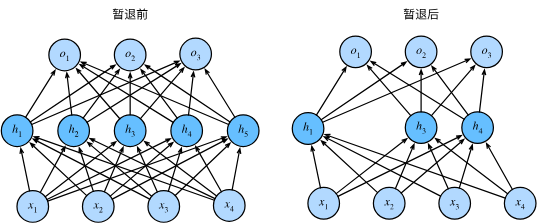

当我们将暂退法应用到隐藏层，以$p$的概率将隐藏单元置零时，结果可以看作一个只包含原始神经元子集的网络。如在上图中删除了$h_2$和$h_5$，因此输出的计算不再依赖于$h_2$或$h_5$，并且它们各自的梯度在执行反向传播时也会消失。这样，输出层的计算不能过度依赖于$h_1,...,h_5$的任何一个元素。

## 暂退法从零开始实现

首先实现dropout_layer函数，该函数以dropout的概率丢弃张量输入$X$中的元素，并将剩余部分除以1.0-dropout以实现缩放。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

测试dropout_layer函数。将输入X通过暂退法操作，暂退概率分别为0、0.5和1。

In [5]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  4.,  0.,  0.,  0., 12., 14.],
        [16., 18.,  0., 22., 24., 26., 28.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


### 定义模型参数
使用Fashion-MNIST数据集。定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元。

In [6]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

### 定义模型

将暂退法应用于每个隐藏层的输出（在激活函数之后），
并且为每一层分别设置暂退概率。

下面的模型将第一个和第二个隐藏层的暂退概率分别设置为0.2和0.5，
并且暂退法只在训练期间有效。

In [7]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

### 训练和测试

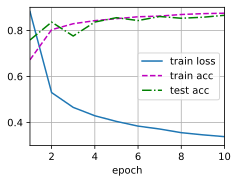

In [9]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 简洁实现

In [10]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

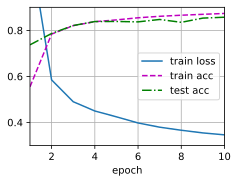

In [11]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)